In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

2024-04-25 19:06:47.574637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 19:06:47.574742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 19:06:47.688050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')


In [3]:
# Prepare data
X = train.drop('label', axis=1).values / 255.0
y = train['label'].values
X_test = test.drop(test.columns[0], axis=1).values / 255.0

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [6]:
# Create DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test) 

# XGBoost parameters
params = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 10,
    'eval_metric': ['mlogloss', 'merror']
}

num_boost_round = 300
evals_result = {}  # Correctly initializing the dictionary to store evaluation results

# Define evals correctly as a list of tuples
evals = [(dtrain, 'train'), (dval, 'eval')]

# Train the model with the correctly defined evals and evals_result
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=evals, evals_result=evals_result, early_stopping_rounds=20)


[0]	train-mlogloss:1.44312	train-merror:0.17450	eval-mlogloss:1.44292	eval-merror:0.17783
[1]	train-mlogloss:1.12321	train-merror:0.12243	eval-mlogloss:1.12378	eval-merror:0.12100
[2]	train-mlogloss:0.91381	train-merror:0.10252	eval-mlogloss:0.91723	eval-merror:0.10450
[3]	train-mlogloss:0.75960	train-merror:0.08993	eval-mlogloss:0.76458	eval-merror:0.09483
[4]	train-mlogloss:0.64458	train-merror:0.08293	eval-mlogloss:0.65113	eval-merror:0.08667
[5]	train-mlogloss:0.55422	train-merror:0.07578	eval-mlogloss:0.56167	eval-merror:0.07900
[6]	train-mlogloss:0.48376	train-merror:0.06993	eval-mlogloss:0.49188	eval-merror:0.07317
[7]	train-mlogloss:0.42667	train-merror:0.06580	eval-mlogloss:0.43514	eval-merror:0.06750
[8]	train-mlogloss:0.38107	train-merror:0.06148	eval-mlogloss:0.39054	eval-merror:0.06417
[9]	train-mlogloss:0.34311	train-merror:0.05793	eval-mlogloss:0.35400	eval-merror:0.06183
[10]	train-mlogloss:0.30960	train-merror:0.05354	eval-mlogloss:0.32076	eval-merror:0.05717
[11]	trai

In [7]:
# Predict on training and validation set
train_preds = bst.predict(dtrain)
val_preds = bst.predict(dval)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

Training accuracy: 99.95%
Validation accuracy: 98.13%


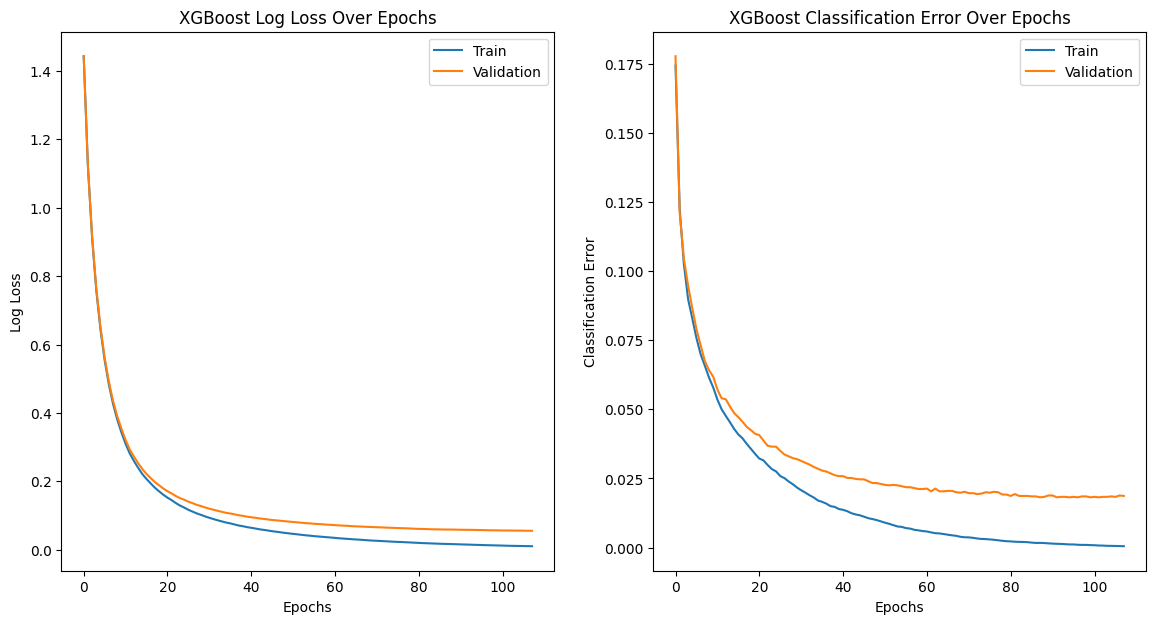

In [8]:
# Extract values from evals_result for plotting
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

# Plotting log loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation')
plt.title('XGBoost Log Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()

# Plotting classification error
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['merror'], label='Train')
plt.plot(x_axis, evals_result['eval']['merror'], label='Validation')
plt.title('XGBoost Classification Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.legend()
plt.show()

In [9]:
test_preds = bst.predict(dtest)  # Predicting the test set
# Prepare submission
submission_df = pd.DataFrame({
    'id': test.iloc[:, 0],  # Assuming the first column is 'id'
    'label': test_preds.astype(int)
})
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print("Submission file for XGBoost created!")
print(submission_df.head())

Submission file for XGBoost created!
   id  label
0   0      3
1   1      0
2   2      2
3   3      6
4   4      7
